# **Table of Contents**
1. [Introduction](#1)
2. [Case study](#2)
3. [Explore Data with the plot method](#3)
4. [Split the data into training and testing](#4)
5. [Implementation with StatsForecast](#5)
6. [Evaluate the model](#6)
7. [Exogenous variables](#7)
8. [Splitting training and test data with exogenous variables](#8)
9. [Implementation of StatsForecast with exogenous variables](#9)
10. [Evaluate the model for exogenous variables](#10)
11. [Conclusion](#11)
12. [References](12)

<a id="1"></a> 
# **Introduction**

<a id="2"></a>
# **Case study**

# Getting Libraries


In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

# StatsForecast
# ==============================================================================
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

# Tool sklearn
# ==============================================================================
from sklearn.preprocessing import LabelEncoder

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

/Users/user/Documents/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [14]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#6495ED',  # #212946  '#99FFDE', '#ffde99', '#de99ff'  'coral','#FFDAB9','yellowgreen','#6495ED'
    'axes.facecolor': 'gray',
    'savefig.facecolor': 'yellowgreen',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)
# Define the plot size
# ==============================================================================

plt.rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# Load datasets

In [3]:
# Load datasets
train_data = pd.read_csv('../tutorial/train.csv')
meal_info = pd.read_csv('../tutorial/meal_info.csv.xls')
center_info = pd.read_csv('../tutorial/fulfilment_center_info.csv.xls')

In [4]:
# Merge datasets for a consolidated view
full_data = train_data.merge(meal_info, on='meal_id', how='left')
full_data = full_data.merge(center_info, on='center_id', how='left')

The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [5]:
full_data["unique_id"]="1"
full_data=full_data.rename(columns={"week": "ds", "num_orders": "y"})
full_data.head()

,id,ds,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,y,category,cuisine,city_code,region_code,center_type,op_area,unique_id
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0,1


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   ds                     456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   y                      456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

<a id="3"></a>
# **Explore Data with the plot method**

# Utility Function

In [15]:
# EDA Functions
def plot_distributions(data, variables, titles):
    #sns.set_style("whitegrid")
    plt.figure(figsize=(18, 5))
    for i, var in enumerate(variables):
        plt.subplot(1, 3, i+1)
        sns.histplot(data[var], bins=50, kde=True)
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

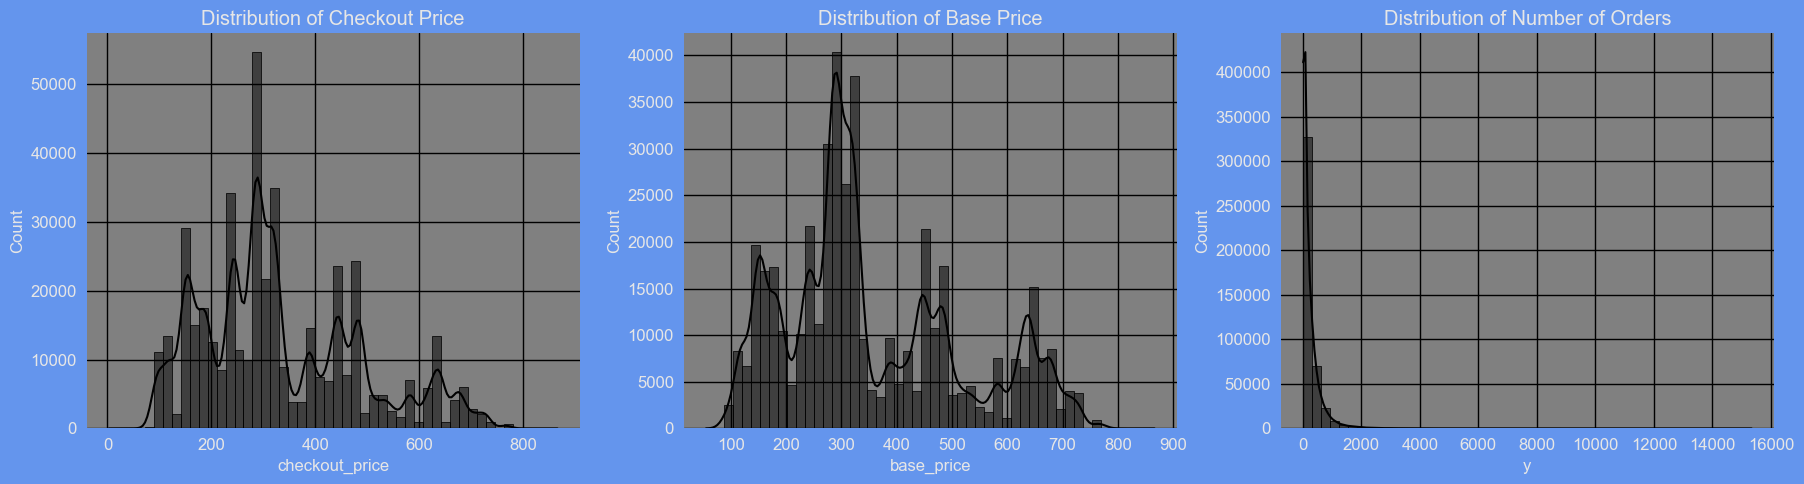

In [16]:
variables_to_plot = ['checkout_price', 'base_price', 'y']
titles = ['Distribution of Checkout Price', 'Distribution of Base Price', 'Distribution of Number of Orders']
plot_distributions(full_data, variables_to_plot, titles)

In [17]:
def plot_weekly_orders(data):
    weekly_orders = data.groupby('ds')['y'].sum().reset_index()
    sns.lineplot(x='ds', y='y', data=weekly_orders)
    plt.title('Trend of Total Orders Over Weeks')
    plt.show()

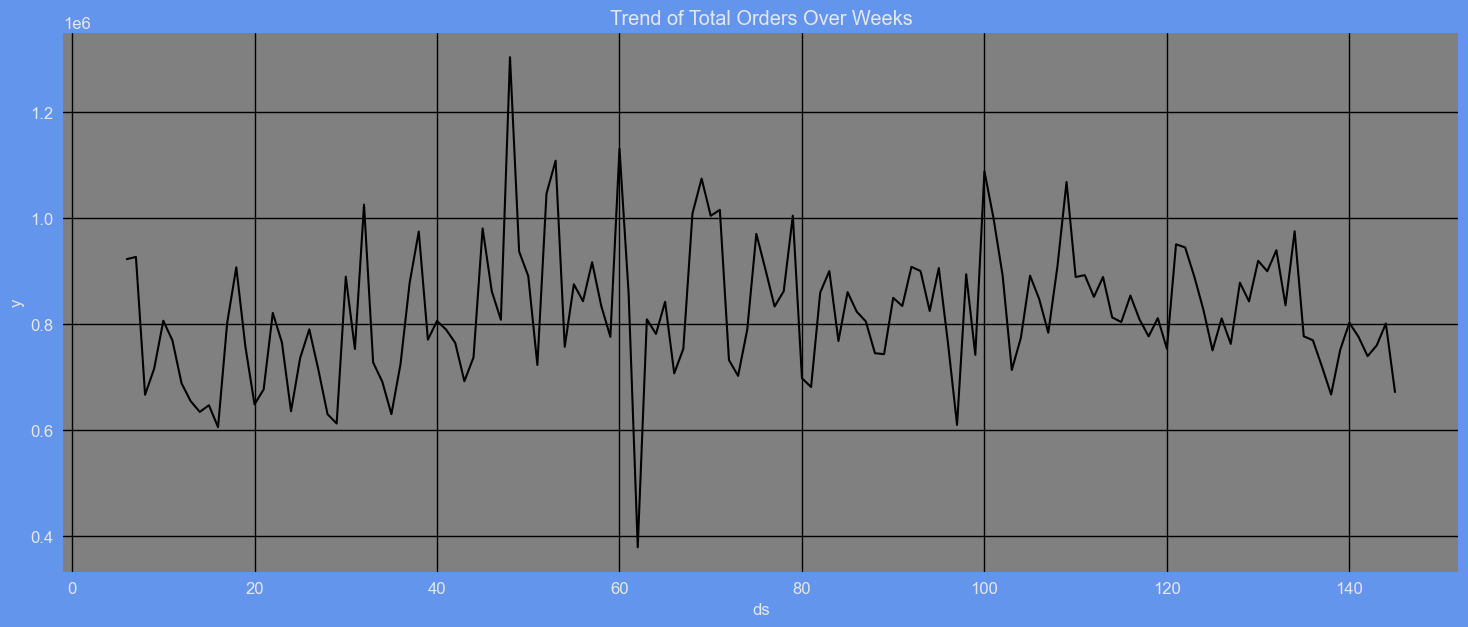

In [18]:
plot_weekly_orders(full_data)


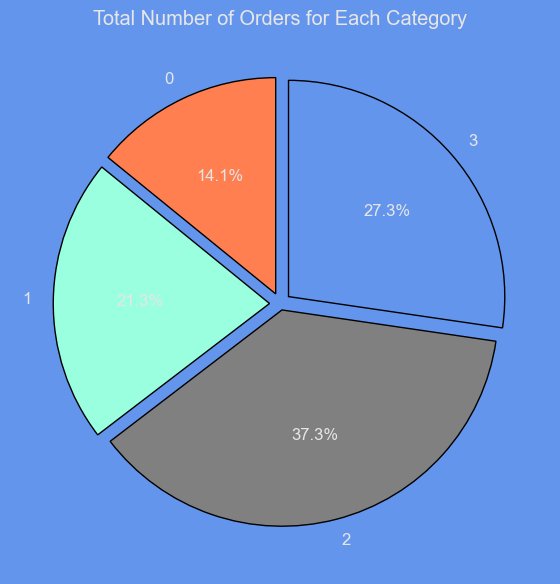

In [19]:
plt.figure(figsize=(18,6))
colors = ['coral','#99FFDE','gray','#6495ED']
plt.pie(full_data.groupby(['cuisine']).y.sum(),
    labels=full_data.groupby(['cuisine']).y.sum().index,
    shadow=False,
    colors=colors,
    explode=(0.05, 0.05, 0.03,0.05),
    startangle=90, 
    autopct='%1.1f%%',pctdistance=0.6,
    textprops={'fontsize': 12})
plt.title('Total Number of Orders for Each Category')
plt.tight_layout()
plt.show()

Italian Cuisine has the highest number of orders with Continental cuisine being the least.

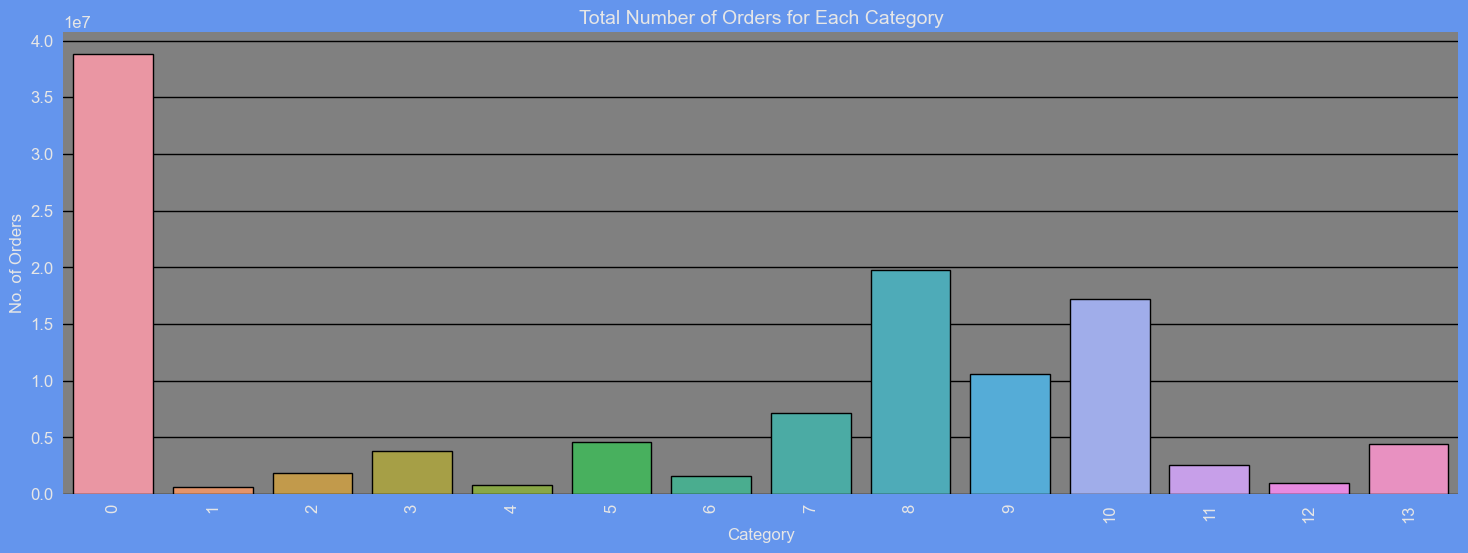

In [20]:
fig=plt.figure(figsize=(18,6))

plt.xticks(rotation=90,fontsize=12)
plt.title('Total Number of Orders for Each Category',fontdict={'fontsize':14})
sns.barplot(y='y', x='category', data=full_data.groupby('category').y.sum().sort_values(ascending=False).reset_index()); #palette='YlOrRd_r'
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Category',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);

We could see that Beverages are the food category which has the higest number of orders and Biriyani is the food category with least number of orders.

In [21]:
# Data Preparation
label_encoders = {}
categorical_columns = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'category', 'cuisine', 'city_code', 'region_code', 'center_type']
for column in categorical_columns:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

# Create lag features
for week_lag in [1, 2, 3, 4, 5]:
    full_data[f'lag_{week_lag}'] = full_data.groupby(['center_id', 'meal_id'])['y'].shift(week_lag)

# Removing NA values
full_data = full_data.dropna()

<a id="4"></a>
# **Split the data into training and testing**

Let's divide our data into two parts:

1. Data to train the model.
2. Data to test the model, here we will use the last 30 daily.

In [22]:
df1=full_data.groupby("ds")[["y"]].sum().reset_index()
df1["unique_id"]="1"

In [23]:
train = df1[df1.ds<=133] 
test=df1[(df1['ds'] > 133)]

train.shape, test.shape

((123, 3), (12, 3))

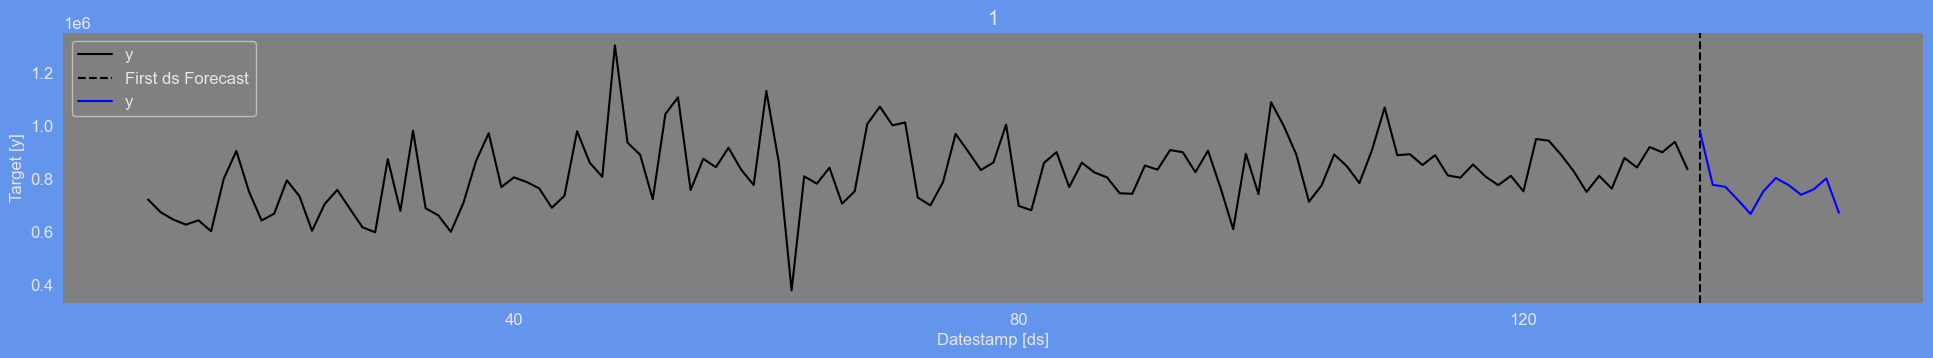

In [24]:
StatsForecast.plot(train, test,max_insample_length=300)

<a id="5"></a>
# **Implementation with StatsForecast**

We are going to train the `Seasonal Exponential Smoothing Optimized` model, using the `SeasonalExponentialSmoothingOptimized` function. This model will help us forecast user demand in the next 12 week.

In [26]:
from statsforecast import StatsForecast
from statsforecast.models import  AutoARIMA,  SeasonalNaive,Holt, HoltWinters,  MSTL, AutoCES, AutoETS, AutoTheta, SeasonalExponentialSmoothingOptimized

In [49]:
season_length = 52 # Daily data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [SeasonalNaive(season_length=season_length),
          SeasonalExponentialSmoothingOptimized(season_length=season_length),
          MSTL(
              season_length=[7,365], # seasonalities of the time series 
              trend_forecaster=AutoARIMA() )# model used to forecast trend
          ]

In [50]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=train,
    models=models,
    freq='W', 
    n_jobs=-1)

## **Fit the Model**

In [51]:
sf.fit()

StatsForecast(models=[SeasonalNaive,SeasESOpt,MSTL])

## **Predict Method**

In [52]:
Y_hat = sf.predict(horizon)
Y_hat

,ds,SeasonalNaive,SeasESOpt,MSTL
unique_id,,,,
1,134,859300.0,873261.0000,544859.6250
1,135,899996.0,681056.5000,679701.0625
1,136,768248.0,978572.5000,739599.6875
1,137,860351.0,690337.3125,806297.8750
1,138,823474.0,663711.7500,678571.3750
1,139,805015.0,601797.8125,555251.2500
1,140,745113.0,710112.5625,713929.9375
1,141,743230.0,866294.9375,730412.8750
1,142,849542.0,970056.6875,771002.3125


## **Forecasting Plot**

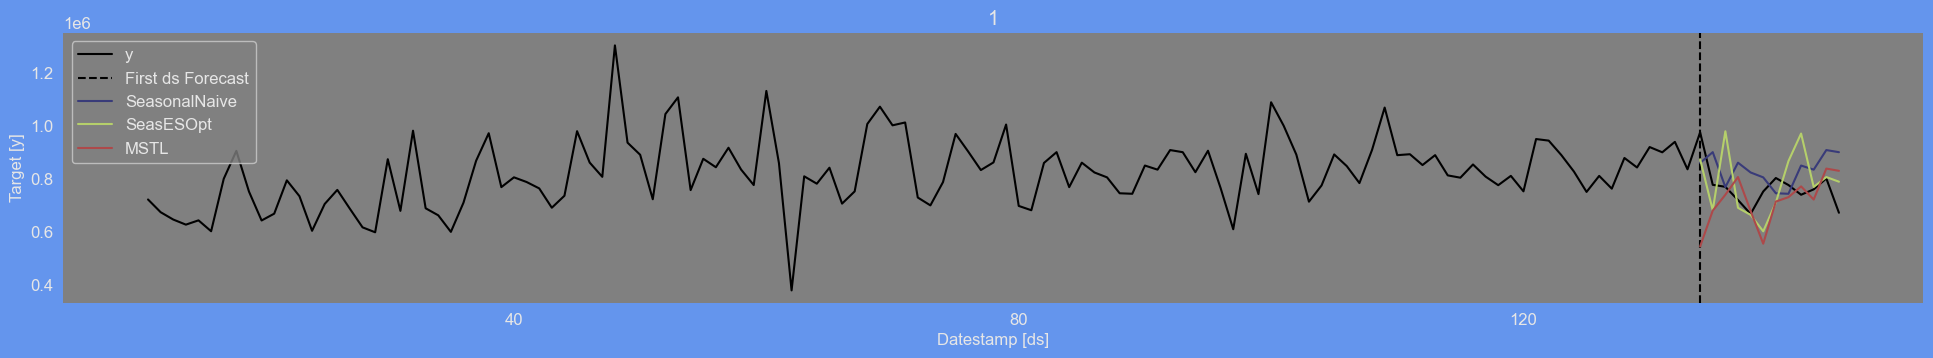

In [59]:
StatsForecast.plot(df1, Y_hat, )

<a id="6"></a>
# **Evaluate the model**

In [40]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)
from utilsforecast.evaluation import evaluate

In [41]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = pd.merge(y_true,y_pred, how='left', on=['ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values,
                                                 y_true[model].values,
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [58]:
print(evaluate_performace(train, test,Y_hat.reset_index() , models=['SeasonalNaive',
       'SeasESOpt',   'MSTL'])
)

                   mase            mae       mape           rmse      smape
SeasonalNaive  0.644930   99950.666667  13.434738  115809.741419  12.456440
SeasESOpt      0.609551   94467.609375  12.335827  119087.837862  11.910209
MSTL           0.672481  104220.489583  12.895373  152803.699153  14.138221


In [ ]:
season_length = 52 # Daily data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [AutoARIMA(season_length=season_length),
          AutoETS(season_length=season_length),
          AutoCES(season_length=season_length),
          AutoTheta(season_length=season_length),
          SeasonalNaive(season_length=season_length),
          SeasonalExponentialSmoothingOptimized(season_length=season_length),
          HoltWinters(season_length=season_length, error_type='A', alias='Hws_add'),
          HoltWinters(season_length=season_length, error_type='M', alias='Hws_mul'),
          Holt(season_length=season_length, error_type="A", alias="Holt_Add"),
          Holt(season_length=season_length, error_type="M", alias="Holt_Multi"),
          MSTL(
              season_length=[7,365], # seasonalities of the time series 
              trend_forecaster=AutoARIMA() )# model used to forecast trend
          ]

https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/data?select=train.csv